# Cas protein and spacer cassette analysis 
### Relating expression to spacer cassette size (hopefully)

Plan:
1. Filter Cas protein results in database to only those that are near a CRISPR casette, and/or filter only high e-value hits or certain protein types. 
2. Get neighbouring casette lengths (copy code from locus number of spacers analysis)
3. Get DNA for *cas* genes and get codons, run through a codon usage analyzer

Will need to download genomes as well.

### To-do
- Check git log on school Lenovo, get details of database creation (number of genomes analyzed, CRISPRfinder parameters, etc)
- 

## Methods

All bacterial and archaeal genome sequences available in NCBI in the vicinity of July 2017 and January 2018 were processed using [CRISPRfinder](https://crisprcas.i2bc.paris-saclay.fr/CrisprCasFinder/Index), downloaded to run locally. Approximately 6000 genomes were processed. (Note: check the git log and try to find out the exact number of genomes that were processed, parameters for CRISPRfinder, etc). 

3411 genomes were found to contain one or more CRISPR loci as detected by CRISPRfinder. 

A list of 393 cas protein HMM profiles was obtained from Makarova et al. (2015). Some of these profiles were publicly available; the others that were custom designed by Makarova et al. were also made available ([ftp://ftp.ncbi.nih.gov/pub/wolf/_suppl/CRISPR2015/](ftp://ftp.ncbi.nih.gov/pub/wolf/_suppl/CRISPR2015/)). We used [hmmer](http://www.hmmer.org/) to detect matches to the *cas* profiles and stored high-scoring matches in a database. 

Of the detected *cas* proteins, we used any that were within 50 000 base pairs of a CRISPR spacer array for the analysis.

In [3]:
%matplotlib inline

In [2]:
import requests
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import pandas as pd
from scipy import stats
from tqdm import tqdm
from Bio import SeqIO

sns.set_palette("husl")

In [4]:
#Url of the phageParser API
apiurl = 'https://phageparser.herokuapp.com'
#Get the initial page for listing of accessible objects and get url for organisms and casproteins
url_json=requests.get(apiurl).json()
organisms_url = url_json['organisms']
cas_proteins_url = url_json['casproteins']
organism_cas_url = url_json['organismcas']
loci_url = url_json['loci']

In [5]:
#Iterate through each page and merge the json response into a dictionary for cas proteins
cas_protein_dict = {}
r=requests.get(cas_proteins_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = cas_proteins_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    cas_protein_objs = payload['cas_proteins']
    for cas_protein_obj in cas_protein_objs:
        cas_protein_dict[cas_protein_obj['id']] = cas_protein_obj

In [6]:
#Iterate through each page and merge the json response into a dictionary for organisms
organism_dict = {}
r=requests.get(organisms_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1,last_page+1)):
    url = organisms_url+'?page={}&include[]=cas_proteins&include[]=loci.spacers'.format(page)
    payload = requests.get(url).json()
    organism_objs = payload['organisms']
    for organism_obj in organism_objs:
        organism_dict[organism_obj['id']] = organism_obj

100%|██████████| 7/7 [01:23<00:00, 11.60s/it]


In [7]:
# Iterate through each page and merge the json response into a dictionary for organism_cas
# this takes a long time
organism_cas_dict = {}
r = requests.get(organism_cas_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1, last_page+1)):
    url = organism_cas_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    organism_cas_objs = payload['organism_cas_proteins']
    for organism_cas_obj in organism_cas_objs:
        organism_cas_dict[organism_cas_obj['id']] = organism_cas_obj

100%|██████████| 446/446 [07:46<00:00,  1.06it/s]


In [8]:
# Iterate through each page and merge the json response into a dictionary for loci
loci_dict = {}
r = requests.get(loci_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1, last_page+1)):
    url = loci_url+'?page={}&include[]=spacers'.format(page)
    payload = requests.get(url).json()
    loci_objs = payload['locus']
    for locus_obj in loci_objs:
        loci_dict[locus_obj['id']] = locus_obj

100%|██████████| 18/18 [01:20<00:00,  4.32s/it]


In [9]:
# create dictionary with the info and positions of all cas proteins in each organism
# note: this may be longer than the list of cas proteins in the organism dict, since some proteins may appear twice
from collections import defaultdict

organism_to_cas_dict = defaultdict(dict)
for i, values in organism_cas_dict.items():
    organism_to_cas_dict[values['organism']][i] = values

### Retain only cas proteins near a cassette

In [10]:
distance_from_locus = 50000 # base pairs, look up what would be a good value
# a cas9 sequence that I randomly found is like 9000 bp, so 50 000 seems like a reasonable cutoff.
# also the cutoff doesn't really matter - the numbers are the same whether the cutoff is 50 000 or 500 000

In [11]:
organism_names = []
loci = []
cas_genes = []
organism_names_all = []
cas_near_cassette_dict = defaultdict(dict)

for organism_id in organism_dict.keys():

    # search_window[0] must be less than search_window[1]

    search_windows = {}
    for locus in organism_dict[organism_id]['loci']:
        # check that start is less than end
        if not locus['genomic_start'] < locus['genomic_end']:
            print('end is less than start')
        search_windows[locus['id']] = {'window': [locus['genomic_start'] - 1000, locus['genomic_end'] + 1000]}
    
    for locus_id, windows in search_windows.items():
        for cas_id, values in organism_to_cas_dict[organism_id].items():
            #print(values['genomic_start'])
            if values['genomic_start'] > windows['window'][0] and values['genomic_end'] < windows['window'][1]:
                #print(organism_id, organism_dict[organism_id]['accession'], organism_dict[organism_id]['name'], locus_id)
                organism_names.append("%s %s\n" %(organism_dict[organism_id]['accession'], organism_dict[organism_id]['name']))
                loci.append(locus_id)
                cas_genes.append(values['casprotein'])
                cas_near_cassette_dict[organism_id][cas_id] = values
                cas_near_cassette_dict[organism_id][cas_id]['locus'] = locus_id # also add locus id
                
    organism_names_all.append("%s %s\n" %(organism_dict[organism_id]['accession'], organism_dict[organism_id]['name']))
                

In [12]:
# create dictionary linking accession numbers and organism IDs
accession_to_organism_id = {}
for key, values in organism_dict.items():
    accession_to_organism_id[values['accession']] = key

In [13]:
print(len(set(organism_names)))
print(len(set(loci)))
print(len(set(cas_genes)))
print(len(cas_genes))
print(len(cas_protein_dict))

473
590
202
731
394


In [14]:
# save list of organisms that have cas proteins near casettes
organism_names = list(set(organism_names))

with open('organism_names.txt', 'w') as file:
    for line in organism_names:
        file.write(line)
        
organism_names_all = list(set(organism_names_all))

with open('organism_names_all.txt', 'w') as file:
    for line in organism_names_all:
        file.write(line)
        

In [15]:
# create accession list
!cat organism_names.txt | cut -d" " -f1 > organism_accessions.txt

!cat organism_names_all.txt | cut -d" " -f1 > organism_accessions_all.txt

# download all organism genomes that were found to be hits
#!cat organism_accessions.txt | python ../parserscripts/acc2gb.py your@email.com nuccore fasta_cds_na > cas_bacteria.dat

Need CDS regions for the AnaCoDa thing, so to download CDS fasta I think use `fasta_cds_na` (nucleotides for cds) or `fasta_cds_aa` (translated amino acids for cds). 

In [ ]:
# split fasta file for all organisms into files separated by organism - only run once

current_accession = 0
past_accession = 0

for record in tqdm(SeqIO.parse("cas_bacteria.dat", "fasta")):
    header = record.id
    accession = header.rsplit('|')[1].rsplit('.')[0]
    current_accession = accession
    if current_accession != past_accession: # start a new file
        with open("%s.fasta" %accession, "w") as output_handle:
            SeqIO.write(record, output_handle, "fasta")
    else:
        with open("%s.fasta" %accession, "a") as output_handle:
            SeqIO.write(record, output_handle, "fasta")
    past_accession = current_accession

In [16]:
folder = "/media/madeleine/My\ Passport/Data/AnaCoDa"
folder_python = "/media/madeleine/My Passport/Data/AnaCoDa"

In [17]:
# link cas genes to their position in the cds list
for record in tqdm(SeqIO.parse("cas_bacteria.dat", "fasta")):
    header = record.id
    accession = header.rsplit('|')[1].rsplit('.')[0]
    org_id = accession_to_organism_id[accession]
    cds_number = int(header.split('_')[-1])
    description = record.description
    
    for key, value in cas_near_cassette_dict[org_id].items():
        try: 
            start = description.index(str(value['genomic_start'])) # this fails if this isn't the cas gene
            end = description.index(str(value['genomic_end']))
            cas_near_cassette_dict[org_id][key]['cds_number'] = cds_number
            #print(org_id)
        except:
            pass

1200252it [00:24, 48254.11it/s]


## Analysis plan

1. Get expression model data using the [AnaCoDa R package](https://rdrr.io/cran/AnaCoDa/f/inst/doc/anacoda.Rmd), save file as `accession-expression.csv`
2. Load expression data using pandas
3. Get cas gene ids: 
```
cas_gene_positions = []
for val in cas_near_cassette_dict[accession_to_organism_id['NZ_CP015184']].values():
    cas_gene_positions.append(val['cds_number'])
```
4. The gene ids-1 are the index for the expression data frame (b/c zero indexing) **expression levels**
5. Get associated locus size: 
```
associated_loci = []
loci_lengths = []
for val in cas_near_cassette_dict[accession_to_organism_id['NZ_CP015184']].values():
    associated_loci.append(val['locus'])
    loci_lengths.append(len(loci_dict[val['locus']]['spacers'])
```
6. Multiple genes may be associated with the same locus, but now `cas_gene_positions` and `associated_loci` should be the same length to match them up (locus indices may be repeated). **locus lengths**

Annddd.... done! Make a sweet plot

One issue to think about: some cas genes might be counted twice as being near two loci, if the loci are very close together. Is this an issue?

Removed genome NZ_CP009177 from organism accession list - causing errors

In [18]:
# get list of which organisms have been analyzed
!ls $folder/*expression.csv | cut -d"-" -f1 | rev | cut -d"/" -f1 | rev > done_accessions.txt 

In [19]:
accessions_done = pd.read_csv("done_accessions.txt", names = ['acc'])

expression_all_list = []
expression_list = []
locus_size_list = []
for accession in accessions_done.acc:

    expression = pd.read_csv("%s/%s-expression.csv" %(folder_python, accession))
    #print(np.mean(expression.PHI))
    names_split = expression["names"].str.rsplit("_", n=1, expand = True)  # split names column from the right to isolate cds position
    expression["protein_position"] = names_split.iloc[:,-1] # create column for cds position
    expression["protein_position"] = pd.to_numeric(expression["protein_position"]) # convert to numeric
    
    expression_all_list.append(expression)
    
    cas_gene_positions = []
    skip_keys = []
    for key, val in cas_near_cassette_dict[accession_to_organism_id[accession]].items():
        try:
            cas_gene_positions.append(val['cds_number'])
        except:
            print("no cds position", str(accession_to_organism_id[accession]), str(key))
            skip_keys.append(key)
    
    if cas_gene_positions == []: # if it's an empty list
        continue
        
    associated_loci = []
    loci_lengths = []
    for key, val in cas_near_cassette_dict[accession_to_organism_id[accession]].items():
        if key in skip_keys:
            continue
        associated_loci.append(val['locus'])
        loci_lengths.append(len(loci_dict[val['locus']]['spacers']))
        
    # get expression level for the cas genes in the organism (normalize by mean expression level)
    expression_vals = expression.loc[expression["protein_position"].isin(cas_gene_positions)].PHI / np.mean(expression.PHI)
    if expression_vals.empty:
        print(expression_vals)
        expression_vals_empty = expression
        cas_gene_positions_empty = cas_gene_positions
    
    #print(np.array(expression_vals), loci_lengths, associated_loci, accession)
    expression_list.append(list(expression_vals))
    locus_size_list.append(loci_lengths)
    

no cds position 2299 12543
no cds position 2268 220471
no cds position 2275 147874


In [ ]:
# flatten lists

expression_list_flat = [item for sublist in expression_list for item in sublist] 
locus_size_list_flat = [item for sublist in locus_size_list for item in sublist] 

sort_inds = np.argsort(locus_size_list_flat)
locus_size_list_flat = np.array(locus_size_list_flat)[sort_inds]
expression_list_flat = np.array(expression_list_flat)[sort_inds]

from scipy.optimize import curve_fit

def line(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

A,B = curve_fit(line, locus_size_list_flat, expression_list_flat)[0] # your data x, y to fit

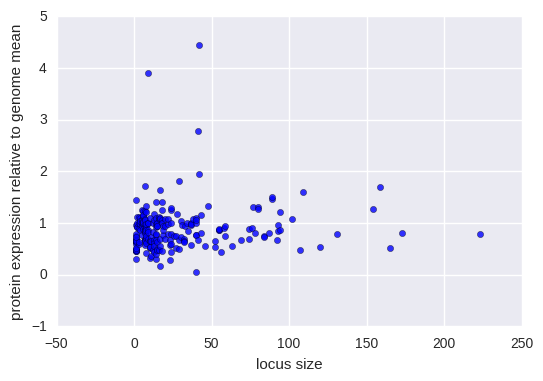

In [23]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.scatter(locus_size_list_flat, expression_list_flat, alpha = 0.8)
#ax.plot(locus_size_list_flat, np.array(locus_size_list_flat)*A+B)
ax.set_xlabel("locus size")
ax.set_ylabel("protein expression relative to genome mean")
plt.savefig("cas_expression_vs_locus_size.png", dpi = 200)

In [ ]:
A,B = curve_fit(line, expression_list_flat, locus_size_list_flat)[0] # your data x, y to fit

In [ ]:
curve_fit(line, expression_list_flat, locus_size_list_flat)[1]

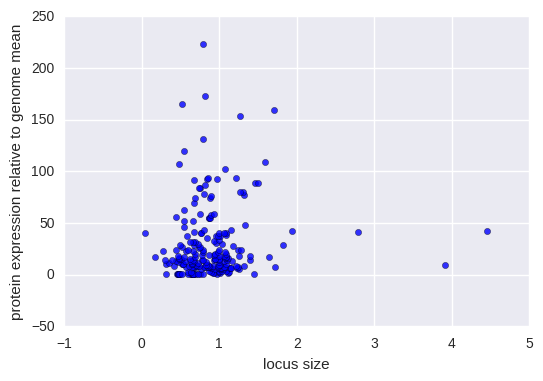

In [24]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.scatter(expression_list_flat, locus_size_list_flat,  alpha = 0.8)
#ax.plot(expression_list_flat, np.array(expression_list_flat)*A+B)
ax.set_xlabel("locus size")
ax.set_ylabel("protein expression relative to genome mean")
plt.savefig("locus_size_vs_cas_expression.png", dpi = 200)

In [25]:
from scipy import stats

In [26]:
stats.spearmanr(expression_list_flat, locus_size_list_flat)

SpearmanrResult(correlation=0.1368814038757733, pvalue=0.041592545124135287)

In [27]:
stats.pearsonr(expression_list_flat, locus_size_list_flat)

(0.098025185377315346, 0.14544637783422598)

From their paper, "the units of phi are proteins per time, and time is scaled such that the the prior for phi satisfies E(phi) = 1." I don't really know what that means, but it hopefully means that results are comparable across genomes?

In [ ]:
ax.flatten()

In [ ]:
accessions_done.loc[i*10,'acc']

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (12,8))

axs = ax.flatten()

for i in range(6):
    axs[i].hist(expression_all_list[i*10].PHI, bins = 20)

    axs[i].set_ylabel("Number of genes")
    print(accessions_done.loc[i*10])
    axs[i].set_title(accessions_done.loc[i*10,'acc'])
axs[4].set_xlabel("Expression (proteins / time)")
plt.tight_layout()
plt.savefig("expression_samples.png", dpi = 200)

In [ ]:
organism_id = 25

search_windows = {}
for locus in organism_dict[organism_id]['loci']:
    # check that start is less than end
    if not locus['genomic_start'] < locus['genomic_end']:
        print('end is less than start')
    search_windows[locus['id']] = {'window': [locus['genomic_start'] - 1000, locus['genomic_end'] + 1000]}



In [ ]:
plot_regions = []
for loci in organism_dict[organism_id]['loci']:
    #print(loci['genomic_start'], loci['genomic_end'])
    plot_regions.append({'position': [loci['genomic_start'], loci['genomic_end']], 'label': 'casette'})
    
for locus_id, windows in search_windows.items():
    for cas_id, values in organism_to_cas_dict[organism_id].items():
        #print(values['genomic_start'])
        if values['genomic_start'] > windows['window'][0] and values['genomic_end'] < windows['window'][1]:
            #print(str(organism_id) + 'yes')
            plot_regions.append({'position': [values['genomic_start'], values['genomic_end']], 
                                 'label': cas_protein_dict[values['casprotein']]['gene']})
            print(values)
    

In [ ]:
plot_regions

In the NCBI database for this organism, the closest CDS regions for the cas genes are:

```
complement(108876..109115)
                     /locus_tag="GZL_RS47195"
                     /inference="COORDINATES: similar to AA
                     sequence:RefSeq:WP_006272258.1"
                     /note="Derived by automated computational analysis using
                     gene prediction method: Protein Homology."
                     /codon_start=1
                     /transl_table=11
                     /product="hypothetical protein"
                     /protein_id="WP_078876378.1"
                     /translation="MVLDPFGGTGTTAAAAKVLGRVGISVDLSPAYTRTAASPSPTPS
                     ANGVARPAGEWGSSSPQSSNWSTLWWMARLRLTLS"
```

```
109222..109647
                     /locus_tag="GZL_RS43525"
                     /old_locus_tag="GZL_p00118"
                     /inference="COORDINATES: ab initio prediction:GeneMarkS+"
                     /note="Derived by automated computational analysis using
                     gene prediction method: GeneMarkS+."
                     /codon_start=1
                     /transl_table=11
                     /product="hypothetical protein"
                     /protein_id="WP_040108171.1"
                     /translation="MHRDVTARPWAREREQARAWQAVVAARAEAAAARPEENVDVSVV
                     APAPVVLPAPRPSAAATEPELEDADDDQDLVLEDLTREQVLGWRDRAATDHQIVHDHI
                     ARYGEHSAQRLFTRAFVATVQRLSHLGHLDLGYTPWRQA"
```

So the good news is, the windows that the database outputs correspond to true CDS regions in NCBI, and we can get the translation from NCBI if necessary. Perhaps we should download the genbank files? or will it work to translate them ourselves?

In [ ]:
fig, ax = plt.subplots(figsize = (20,2))

# get max range needed
min_value = 10**10
max_value = 0
for region in plot_regions:
    if region['position'][0] < min_value:
        min_value = region['position'][0]
    if region['position'][1] > max_value:
        max_value = region['position'][1]
     
    #if region['label'] == 'casette':
    #    colour = 'b'
    #else:
    #    colour = 'g'
    if region['label'] == 'casette':
        ax.fill_between([region['position'][0], region['position'][1]],0,1, color = 'b')
    else:
        ax.fill_between([region['position'][0], region['position'][1]],0,1, label = region['label'])

#ax.set_xlim(1893000, 1910000)
#ax.set_xlim(748000, 753000)
ax.legend(loc='best')
    

In [ ]:
# download a bacterial genome

accession = organism_dict[organism_id]['accession']
print(accession)
print(organism_dict[organism_id]['name'])
!echo "$accession" | python ../parserscripts/acc2gb.py madeleine.bonsma@gmail.com nuccore fasta > "$accession".dat

In [ ]:
from Bio import SeqIO
for record in SeqIO.parse("%s.dat" %accession, "fasta"):
    genome = record.seq

In [ ]:
from Bio import Seq
print(Seq.transcribe(Seq.reverse_complement(genome[109222:109647])))
print(Seq.translate((genome[109222:109647])))

In [ ]:
len(genome[109222:109647])/3

In [ ]:
print(genome[109222:109647])

# Another option
Makarova et al. (2015) also have a table that lists every singe locus and all the gene positions. Let's just use that in combination with the locus data - that's many more data points! 

From the 2015 paper: they use 530 bp as the cutoff for distance between CRISPR array and cas genes. 

In [20]:
makarova_data = pd.read_csv("nrmicro3569-s7_cleaned.csv")

In [21]:
makarova_data.head()

,#Locus ID / GI,(sub)Type / Coordinates,Strand,Genome,Genome partition ID,Gene number on the genome partition,Cas profile ID (CDD ID for non-cas proteins),Cas core,Cas gene
0,# 384117643,CAS-I-E,NaN,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,NaN,NaN,NaN,NaN
1,384117643,114611..117325,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,103.0,COG1203,+,cas3
2,384117644,117387..119042,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,104.0,cd09729,+,cas8e
3,384117645,119042..119602,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,105.0,cd09731,+,cse2gr11
4,384117646,119623..120681,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,106.0,pfam09344,+,cas7


In [22]:
makarova_data.columns

Index(['#Locus ID / GI', '(sub)Type / Coordinates', 'Strand', 'Genome',
       'Genome partition ID', 'Gene number on the genome partition',
       'Cas profile ID (CDD ID for non-cas proteins)', 'Cas core', 'Cas gene'],
      dtype='object')

The locus type and titles are mixed in with columns - will be tricky to sort it out. Each new locus has a hash symbol in the '#Locus ID / GI' column.

In [23]:
makarova_data[["#Locus ID / GI", '(sub)Type / Coordinates']].head()

,#Locus ID / GI,(sub)Type / Coordinates
0,# 384117643,CAS-I-E
1,384117643,114611..117325
2,384117644,117387..119042
3,384117645,119042..119602
4,384117646,119623..120681


In [24]:
# get 'True' wherever a locus starts, get the index of all True
repeats1 = np.arange(len(makarova_data))[makarova_data["#Locus ID / GI"].str.contains('#')] 

# add the length of the data to count the last locus
repeats1 = np.append(repeats1, len(makarova_data)) 

In [25]:
# array giving the length of each locus (# of times label should be repeated)
repeats = repeats1[1:] - repeats1[:-1]
locus_id = np.arange(len(repeats)) # give a unique ID to each locus

In [26]:
locus_id_column = np.repeat(locus_id, repeats)
crispr_types = makarova_data.loc[makarova_data["#Locus ID / GI"].str.contains('#'), "(sub)Type / Coordinates"]
type_column = np.array(np.repeat(crispr_types, repeats))

In [27]:
# assign new columns
makarova_data["locus_id"] = locus_id_column
makarova_data["CRISPR_type"] = type_column

In [28]:
makarova_data.tail(n=20)

,#Locus ID / GI,(sub)Type / Coordinates,Strand,Genome,Genome partition ID,Gene number on the genome partition,Cas profile ID (CDD ID for non-cas proteins),Cas core,Cas gene,locus_id,CRISPR_type
17283,345004205,199240..200190,-,halophilic_archaeon_DL31_uid72619,NC_015954,195.0,cd09709,+,csc2gr7,1946,CAS-I-D
17284,345004206,200187..202673,-,halophilic_archaeon_DL31_uid72619,NC_015954,196.0,cd09712,+,cas10d,1946,CAS-I-D
17285,345004207,202670..203539,-,halophilic_archaeon_DL31_uid72619,NC_015954,197.0,pfam10040,+,cas6,1946,CAS-I-D
17286,345004208,203689..204333,+,halophilic_archaeon_DL31_uid72619,NC_015954,198.0,cls001593,NaN,casR,1946,CAS-I-D
17287,# 189485058,CAS-II-C,NaN,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,NaN,NaN,NaN,NaN,1947,CAS-II-C
17288,189485058,101786..102286,+,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,55.0,cd09643,+,cas9,1947,CAS-II-C
17289,189485059,102302..105400,+,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,56.0,cd09643,+,cas9,1947,CAS-II-C
17290,189485060,105401..106312,+,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,57.0,cd09720,+,cas1,1947,CAS-II-C
17291,189485061,106296..106622,+,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,58.0,mkCas0206,+,cas2,1947,CAS-II-C
17292,# 189485218,CAS-I-C;CAS-II-C,NaN,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,NaN,NaN,NaN,NaN,1948,CAS-I-C;CAS-II-C


In [29]:
# remove the rows that are the locus titles
makarova_data = makarova_data.loc[~makarova_data['#Locus ID / GI'].str.contains('#')]

In [30]:
# number of unique organisms
len(pd.unique(makarova_data['Genome partition ID']))

1263

In [69]:
accessions_all = pd.read_csv("organism_accessions_all.txt", names = ['acc']) # all organisms with CRISPR arrays
accessions = pd.read_csv("organism_accessions.txt", names = ['acc']) # ones with cas near CRISPR array

In [73]:
# get a list of all the organisms that are in either our group or the makarova group
set1 = set(accessions['acc'])
set2 = set(pd.unique(makarova_data['Genome partition ID'])) # makarova genomes with cas loci
set3 = set(accessions_all['acc'])

union = list(set1.union(set2))

intersection_all = list(set3.intersection(set2))

difference = list(set(intersection_all).difference(set1))

print(len(union))

# this many genomes that are in the makarova data have had their expression analyzed
makarova_done = set2.intersection(set(accessions_done['acc']))
print(len(makarova_done))

1469
88


Need CDS regions for the AnaCoDa thing, so to download CDS fasta I think use `fasta_cds_na` (nucleotides for cds) or `fasta_cds_aa` (translated amino acids for cds). 

In [76]:
with open("accessions_overlap.txt", "w") as file:
    for acc in intersection_all:
        file.write(acc + "\n")

In [97]:
done_accessions = pd.read_csv("done_accessions.txt", names = ['acc'])

In [112]:
remaining_to_analyze = pd.DataFrame(list(set(intersection_all).difference(set(done_accessions['acc']))), columns = ['acc'])

In [114]:
len(remaining_to_analyze)

1047

In [117]:
remaining_to_analyze.to_csv("remaining_to_analyze.txt", index = None, header = None)

In [92]:
downloaded_genomes = pd.read_csv("downloaded_genomes.txt",  names = ['acc'])

In [93]:
to_download = list(set(intersection_all).difference(set(downloaded_genomes['acc'])))

In [94]:
len(to_download)

0

In [ ]:
# need to download a few more organisms that aren't in our list

for acc in to_download:
    !echo "$acc" | python ../parserscripts/acc2gb.py your@email.com nuccore fasta_cds_na > "$acc".fasta

In [34]:
makarova_subset = makarova_data[makarova_data['Genome partition ID'].isin(makarova_done)]

In [35]:
len(makarova_subset)

1505

In [52]:
makarova_subset.loc[:,["(sub)Type / Coordinates"]] = makarova_subset["(sub)Type / Coordinates"].astype(str)

/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [53]:
new_cols = makarova_subset["(sub)Type / Coordinates"].str.split(".", expand = True)

In [54]:
makarova_subset["Genomic start"] = new_cols[0]
makarova_subset["Genomic end"] = new_cols[2]

/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [55]:
makarova_subset.head()

,#Locus ID / GI,(sub)Type / Coordinates,Strand,Genome,Genome partition ID,Gene number on the genome partition,Cas profile ID (CDD ID for non-cas proteins),Cas core,Cas gene,locus_id,CRISPR_type,Genomic start,Genomic end
107,332796052,362959..365517,+,Acidianus_hospitalis_W1_uid66875,NC_015518,359.0,"cd09641,mkCas0133",+,cas10,12,CAS-III-D,362959,365517
108,332796053,365597..366034,+,Acidianus_hospitalis_W1_uid66875,NC_015518,360.0,cls000253,+,csm3gr7,12,CAS-III-D,365597,366034
109,332796054,366015..366977,+,Acidianus_hospitalis_W1_uid66875,NC_015518,361.0,mkCas0153,+,csx10gr5,12,CAS-III-D,366015,366977
110,332796055,366967..367326,+,Acidianus_hospitalis_W1_uid66875,NC_015518,362.0,mkCas0186,+,csm2gr11,12,CAS-III-D,366967,367326
111,332796056,367331..368071,+,Acidianus_hospitalis_W1_uid66875,NC_015518,363.0,COG1337,+,csm3gr7,12,CAS-III-D,367331,368071


In [56]:
makarova_subset.loc[makarova_subset["Genomic start"] > makarova_subset["Genomic end"]]

,#Locus ID / GI,(sub)Type / Coordinates,Strand,Genome,Genome partition ID,Gene number on the genome partition,Cas profile ID (CDD ID for non-cas proteins),Cas core,Cas gene,locus_id,CRISPR_type,Genomic start,Genomic end
6666,159901591,99827..100840,+,Herpetosiphon_aurantiacus_DSM_785_uid58599,NC_009973,81.0,cd09634,+,cas1,758,CAS-I-B,99827,100840
8234,261402132,747..1010,+,Methanocaldococcus_vulcanius_M7_uid41131,NC_013407,1.0,cd09725,+,cas2,938,CAS-I-D,747,1010
8242,261402140,9861..10613,-,Methanocaldococcus_vulcanius_M7_uid41131,NC_013407,9.0,cd09759,+,cas6,938,CAS-I-D,9861,10613
12494,541862392,558..1481,-,Serratia_ATCC_39006_uid218470,NC_022268,2.0,cd09719,+,cas1,1418,CAS-I-E,558,1481


Looks like the genomic start is always less than the genomic end. 

Now get the ones that are near loci!

In [57]:
locus_min_max = (makarova_subset.groupby(["Genome partition ID","locus_id"])
                 .agg({"Genomic start": np.min,"Genomic end": np.max}))

locus_min_max = locus_min_max.reset_index()
locus_min_max = locus_min_max.set_index('locus_id')
locus_min_max.head()



,Genome partition ID,Genomic start,Genomic end
locus_id,,,
936,NC_000909,339917,351645
937,NC_000909,1648677,1658533
225,NC_002163,1455569,1459834
1158,NC_002663,358606,369045
1159,NC_002663,1322726,1327185


In [58]:
locus_min_max.loc[225]['Genome partition ID']

'NC_002163'

In [59]:
organism_dict[1]['loci'][0]['genomic_start']

178305

In [60]:
cas_locus_to_crispr_array = {}
cutoff = 530
count = 0
for locus in np.unique(makarova_subset["locus_id"]):
    accession = locus_min_max.loc[locus]['Genome partition ID']
    org_id = accession_to_organism_id[accession]
    cas_locus_start = int(locus_min_max.loc[locus]['Genomic start'])
    cas_locus_end = int(locus_min_max.loc[locus]['Genomic end'])
    
    for loc in organism_dict[org_id]['loci']:
        crispr_array_start = loc['genomic_start']
        crispr_array_end = loc['genomic_end']
        
        if np.abs(crispr_array_start - cas_locus_end) < cutoff or np.abs(crispr_array_end - cas_locus_start) < cutoff:
            count += 1
            try:
                cas_locus_to_crispr_array[locus].append({"locus_id": loc['id'], "crispr_length": len(loc['spacers'])})
            except:
                cas_locus_to_crispr_array[locus] = [{"locus_id": loc['id'], "crispr_length": len(loc['spacers'])}]

In [61]:
locus_num = 1948
locus_min_max.loc[locus_num]['Genome partition ID']

'NC_020419'

In [62]:
accession = "NC_020419"

In [63]:
cas_gene_positions = makarova_subset[makarova_subset['locus_id'] == locus_num]["Gene number on the genome partition"]

In [64]:
expression = pd.read_csv("%s/%s-expression.csv" %(folder_python,accession))

In [65]:
names_split = expression["names"].str.rsplit("_", n=1, expand = True)  # split names column from the right to isolate cds position
expression["protein_position"] = names_split.iloc[:,-1] # create column for cds position
expression["protein_position"] = pd.to_numeric(expression["protein_position"]) # convert to numeric

In [66]:
# get nearby loci

locus_lengths = []
for locus in cas_locus_to_crispr_array[locus_num]:
    locus_lengths.append(locus['crispr_length'])


In [67]:
expression.loc[expression["protein_position"].isin(cas_gene_positions)].PHI / np.mean(expression.PHI)

214    0.533940
215    1.281242
216    0.944760
217    1.240539
218    1.038434
219    1.226273
220    1.225218
221    1.146164
222    1.131724
223    1.074061
Name: PHI, dtype: float64

In [68]:
locus_min_max.index

Int64Index([ 936,  937,  225, 1158, 1159,  594, 1043,  273,  274, 1245,
            ...
            1948,  624,  675, 1418, 1419, 1420,   39,   40,  128,  235],
           dtype='int64', name='locus_id', length=161)

In [69]:
cas_locus_to_crispr_array.keys()

dict_keys([1793, 1366, 519, 777, 1291, 14, 273, 274, 1043, 535, 536, 1817, 26, 1819, 645, 1313, 1058, 291, 292, 39, 40, 814, 1583, 1840, 308, 312, 569, 1419, 324, 1351, 328, 590, 56, 594, 1363, 84, 85, 86, 1367, 1368, 349, 350, 327, 611, 624, 233, 128, 388, 389, 1159, 1672, 1417, 1930, 1303, 1304, 915, 410, 1948, 1306, 416, 417, 674, 675, 936, 1449, 938, 171, 436, 438, 951, 1465, 1466, 446, 191, 961, 962, 707, 1478, 1839, 714, 1314, 721, 212, 984, 1242, 1244, 1245, 734, 1248, 225, 1763, 1764, 487, 488, 489, 1775, 168, 1014, 169])

In [70]:
expression_list = []
locus_size_list = []
locus_id_list = []
for locus_num in np.unique(list(cas_locus_to_crispr_array.keys())):
    accession = locus_min_max.loc[locus_num]['Genome partition ID']
    expression = pd.read_csv("%s/%s-expression.csv" %(folder_python,accession))
    #print(np.mean(expression.PHI))
    names_split = expression["names"].str.rsplit("_", n=1, expand = True)  # split names column from the right to isolate cds position
    expression["protein_position"] = names_split.iloc[:,-1] # create column for cds position
    expression["protein_position"] = pd.to_numeric(expression["protein_position"]) # convert to numeric
    
    expression_all_list.append(expression)
    
    cas_gene_positions = makarova_subset[makarova_subset['locus_id'] == locus_num]["Gene number on the genome partition"]
    
    expression_vals = expression.loc[expression["protein_position"].isin(cas_gene_positions)].PHI / np.mean(expression.PHI)
    
    # find nearby loci - compare locus positions with cas gene positions?

    for locus in cas_locus_to_crispr_array[locus_num]:
        locus_length = locus['crispr_length']
        locus_size_list.append([locus_length]*len(expression_vals))
        expression_list.append(expression_vals)
        locus_id_list.append([locus_num]*len(expression_vals))
  

In [71]:
# flatten lists

expression_list_flat = [item for sublist in expression_list for item in sublist] 
locus_size_list_flat = [item for sublist in locus_size_list for item in sublist] 
locus_id_list_flat = [item for sublist in locus_id_list for item in sublist]

sort_inds = np.argsort(locus_size_list_flat)
locus_size_list_flat = np.array(locus_size_list_flat)[sort_inds]
expression_list_flat = np.array(expression_list_flat)[sort_inds]
locus_id_list_flat = np.array(locus_id_list_flat)[sort_inds]

In [ ]:
# make data frame with expression list, locus size, and locus ID to group by locus ID
# also add grouping info for CRISPR type?
expression_df = pd.DataFrame(expression_list_flat)

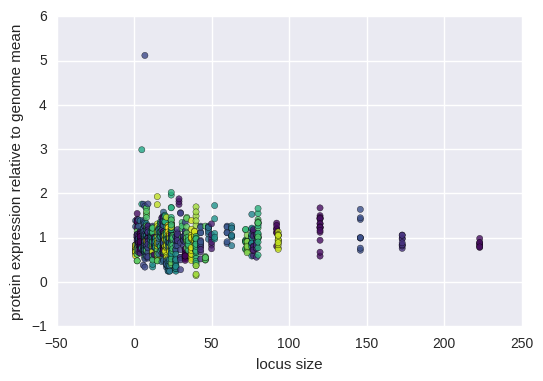

In [72]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.scatter(locus_size_list_flat, expression_list_flat, alpha = 0.8, c = locus_id_list_flat, cmap = "viridis")
#ax.plot(locus_size_list_flat, np.array(locus_size_list_flat)*A+B)
ax.set_xlabel("locus size")
ax.set_ylabel("protein expression relative to genome mean")
plt.savefig("makarova_cas_expression_vs_locus_size.png", dpi = 200)

## Normalize to some common genes

Instead of normalizing to the total expression for a cell, normalize to a set of 'housekeeping' or reference genes that most or all organisms should constitutively express. Genes involved in DNA replication are good candidates, since we would like things to be relative to cell generation times.

From some googling:

| Gene name | String to search in CDS annotation | Gene function | Approx length | Reference |
| --------- | ---------------------------------- | ------------- | ------------- | --------- |
| recombinase A | recA                               |      | | |
|DNA gyrase A subunit| gyrA                             |      | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), |
|DNA gyrase B subunit| gyrB                            |      | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg),   |
| chaperone DnaJ | dnaJ | | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), [PFAM](https://pfam.xfam.org/family/DnaJ) |
|  | rpoA | | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), |
|  | rpoB |  |  | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg),  |
|  | atpD | | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), |
|  | infB| | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), |
|  |  |  |  |  |
|  |  |  |  |  |
